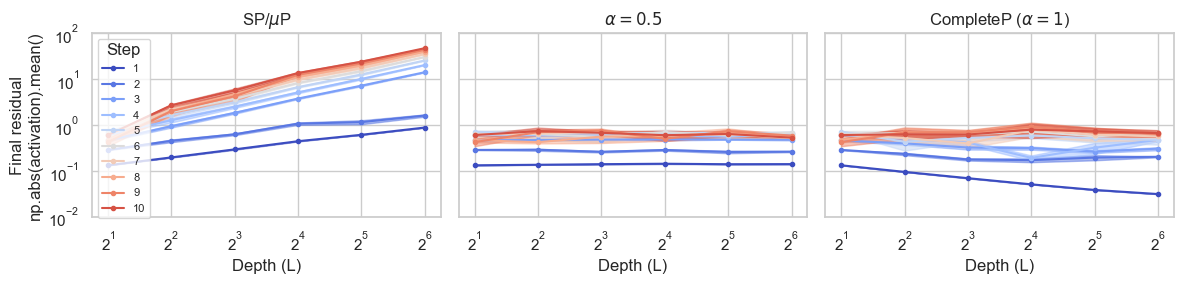

In [18]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
sns.set(style='whitegrid')

df_dict = {} # {parameterization: {job_name: df}}
for parameterization in os.listdir():
    df_dict[parameterization] = {}
    if parameterization == 'plot.ipynb':
        continue
    for job_name in os.listdir(os.path.join(parameterization, 'out')):
        df_dict[parameterization][job_name] = pd.read_csv(os.path.join(parameterization, 'out', job_name, 'log.csv'))

class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

layer_types = [
    # ('token_embedding_act_abs_mean', 'Word Embedding', (1.5e-2, 3.5e-2)),
    # ('attn_act_abs_mean', 'Attention Output', (1e-2, 1e4)),
    # ('mlp_act_abs_mean', 'FFN Output', (1e-2, 1e4)),
    ('last_layer_act_abs_mean', 'Final Residual Stream', (1e-2, 1e2)),
    # ('lm_head_act_abs_mean', 'Output Logits', (5e-2, 1e2)),
]
parameterizations = [
    ('sp_and_mup', r'SP/$\mu$P'),
    ('depth_alpha_05', r'$\alpha=0.5$'),
    ('depth_alpha_1_aka_completep', r'CompleteP ($\alpha=1$)'),
]
seeds = [1,2,3]
depths = [2,4,8,16,32,64]
# t_max = 1
# t_max = 2
t_max = 10

color_helper = MplColorHelper('coolwarm', 0, t_max)
n_cols = len(parameterizations)
n_rows = len(layer_types)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = np.array(axes).reshape((n_rows, n_cols))

for parameterization_idx, (parameterization, parameterization_str) in enumerate(parameterizations):
    results_matrix = np.zeros((len(layer_types), t_max, len(depths), len(seeds))) # (layer_type, t, width, seed)
    for depth_idx, depth in enumerate(depths):
        for seed_idx, seed in enumerate(seeds):
            depth_str = float(depth) if depth != 0 else int(depth)
            job_name = f'depth{depth}_width256_seed{seed}'
            try:
                ckpt_df = df_dict[parameterization][job_name]
            except:
                print(parameterization, job_name)
            if len(ckpt_df) == 0 or ckpt_df['step'].max() == 0:
                print(job_name)
                continue
            for layer_type_idx, (layer_type, layer_type_str, ylims) in enumerate(layer_types):
                results_matrix[layer_type_idx, :, depth_idx, seed_idx] = ckpt_df[layer_type].dropna().values[:t_max].flatten()

    for layer_type_idx, (layer_type, layer_type_str, ylims) in enumerate(layer_types):
        ax = axes[layer_type_idx, parameterization_idx]
        for t in range(0,t_max):
            means = []
            stderrs = []
            for depth_idx, depth in enumerate(depths):
                nnz_results = results_matrix[layer_type_idx, t, depth_idx][results_matrix[layer_type_idx, t, depth_idx] != 0]
                means.append(nnz_results.mean())
                stderrs.append(np.std(nnz_results, ddof=1) / np.sqrt(len(nnz_results)))
            means = np.array(means)
            stderrs = np.array(stderrs)
            ax.plot(depths, means, label=f'{t+1}', color=color_helper.get_rgb(t), marker='.')
            ax.fill_between(depths, means-stderrs, means+stderrs, color=color_helper.get_rgb(t), alpha=0.5)

        ax.set_title(parameterization_str)
        ax.set_xlabel('Depth (L)')
        ax.set_xscale('log', base=2)
        ax.set_yscale('log')
        ax.set_ylim(*ylims)
        if parameterization_idx > 0:
            ax.yaxis.set_ticklabels([])

axes[0, 0].set_ylabel('Final residual\nnp.abs(activation).mean()')
axes[0, 0].legend(loc='upper left', fontsize=8, title='Step')

plt.tight_layout()
plt.show()
plt.close()